In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import json
import csv
import itertools
import h5py
import copy
from pathlib import Path
import sys
from PIL import Image
import re
import time
import os
from scipy.interpolate import interp1d
%matplotlib inline

MOUNT THE DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# REFINED TELBE CLASS -- no obvious bugs
Before future <br>
THINGS I NEED TO DO:
*   The fft function is a little buggy
*   Finding a way to auto detect keys based off common words or phrases
*   Interpolate isnt tested yet
*   Document, examples, README.md



In [ ]:
class Telbe:
    def __init__(self):
        self.meta = {}
        self.Pixel = np.array([])
        self.Time = np.array([])
        self.Signal = np.array([])

    def parse_file(self, file_path, key_pattern=None):
        """
        Parses the input file and optionally extracts metadata from the filename
        based on a provided key pattern.

        Args:
            file_path (str): Path to the file or the file name to be parsed.
            key_pattern (str): A key pattern representing the structure of the filename.
                               Example: 'Num_Type_Element_Fluence_FluenceVal_BandpassFilterval_bandpass_HPFval_HPF'
        """
        file_name = file_path.split('/')[-1]
        words = file_name.split('_')

        if key_pattern:
            self._extract_meta_from_filename(words, key_pattern)

        if 'LockIn' in words:
            self._parse_lockin_file(file_path)
        else:
            self._parse_regular_file(file_path)

    def _extract_meta_from_filename(self, words, key_pattern):
        """
        Extracts metadata from the filename based on a key pattern and stores it in the meta dictionary.

        Args:
            words (list): The components of the filename split by '_'.
            key_pattern (str): A key pattern string that describes the structure of the filename.
        """
        keys = key_pattern.split('_')
        if len(keys) != len(words):
            raise ValueError("Filename components do not match the provided key pattern.")

        for key, word in zip(keys, words):
            self.meta[key] = word

        print(f"Extracted metadata: {self.meta}")


    def _parse_lockin_file(self, file_path):
        """Parses LockIn type files and processes Pixel, Time, and Signal."""
        try:
            data = np.loadtxt(file_path)
            self.Pixel = data[:, 2]
            self.Time = data[:, 0]
            self.Signal = data[:, 1] * 5e3

            #self.Time -= self.Time[0]
            self.Time *= 6.67 #twice because one step of the stage is twice delay of beam

            #idx_max = np.argmax(self.Signal[:120])
            #self.Time -= self.Time[idx_max]
            self.Time-=244.12
            # Extract meta data
            #self._extract_meta(file_path.split('_'), 'WG')
            print('This is a LockIn file.')
        except Exception as e:
            print(f"Error parsing LockIn file: {e}")

    def _parse_regular_file(self, file_path, tester = True):
        """Parses regular files for Pixel, Time, and Signal data."""
        data_section_started = False

        try:
            with open(file_path, 'r') as file:
                for line in file:
                    line = line.strip()
                    if not line:
                        continue

                    if not data_section_started and "Pixel value" in line:
                        data_section_started = True
                        continue

                    if data_section_started:
                        data_line = line.split()
                        if len(data_line) == 3:
                            try:
                                self.Pixel = np.append(self.Pixel, float(data_line[0]))
                                self.Time = np.append(self.Time, float(data_line[1]))
                                self.Signal = np.append(self.Signal, float(data_line[2]))
                            except ValueError as e:
                                print(f"Error parsing line '{line}': {e}")
                        else:
                            print(f"Skipping malformed line: '{line}'")
                    elif ":" in line:
                        key, value = line.split(":", 1)
                        self.meta[key.strip()] = value.strip()

            idx_max = np.argmax(self.Signal[10:500])
            if tester == False:
              self.Time = self.Time - self.Time[idx_max]
            else:
              self.Time = self.Time
        except Exception as e:
            print(f"Error parsing regular file: {e}")

    def _extract_meta(self, words, character):
        """Extracts meta information based on a character string."""
        matching_words = [word for word in words if character in word]
        if matching_words:
            self.meta[character] = matching_words[0]

    def to_dataframe(self):
        """Converts the parsed data into a pandas DataFrame.
        In case you like that sort of thing
        """
        return pd.DataFrame({
            'Pixel': self.Pixel,
            'Time, ps': self.Time,
            'Signal': self.Signal
        })

    def calc_fft(self, window=None):
        """Calculates the FFT of the signal, optionally within a window."""
        T = np.mean(np.diff(self.Time))
        sampling_rate = 1 / T

        data = self.Signal
        if window:
            idx_begin = np.searchsorted(self.Time, window[0])
            idx_end = np.searchsorted(self.Time, window[1], side='right') - 1
            print(idx_begin,idx_end)
            data = data[idx_begin:idx_end + 1]

        fft_values = np.fft.fft(data)
        frequencies = np.fft.fftfreq(len(data), T)
        magnitude = np.abs(fft_values)

        self.positive_frequencies = frequencies[:len(frequencies) // 2]
        self.positive_magnitude = magnitude[:len(magnitude) // 2]

        print('FFT calculated. Attributes: positive_frequencies, positive_magnitude.')

    def add_offset(self, param_name, offset):
        """Adds an offset to a specified parameter."""
        if hasattr(self, param_name):
            setattr(self, param_name, getattr(self, param_name) + offset)
            return self
        else:
            raise AttributeError(f"Parameter '{param_name}' does not exist in the object.")

    def combine_data(self, other, combine_attrs):
        """
        Combines specified attributes (like Time, Signal, Pixel) of two Telbe objects.
        Attributes must exist in both objects.

        Args:
            other (Telbe): Another Telbe object to combine with the current one.
            combine_attrs (list): List of attribute names to combine (e.g., ['Time', 'Signal']).

        Returns:
            Telbe: A new Telbe object containing the combined data for specified attributes.
        """
        combined = Telbe()

        for attr in combine_attrs:
            if hasattr(self, attr) and hasattr(other, attr):

                combined_data = np.concatenate((getattr(self, attr), getattr(other, attr)))

                if attr == 'Time':

                    sorted_indices = np.argsort(combined_data)


                    combined.Time = combined_data[sorted_indices]


                    for other_attr in combine_attrs:
                        if other_attr != 'Time':
                            combined_attr_data = np.concatenate((getattr(self, other_attr), getattr(other, other_attr)))
                            setattr(combined, other_attr, combined_attr_data[sorted_indices])
                else:

                    setattr(combined, attr, combined_data)
            else:
                raise AttributeError(f"Both Telbe objects must have the '{attr}' attribute.")
        return combined

    def interpolate_data(self, new_time, kind='linear'):
        """
        Interpolates the Signal data to new time values.

        Args:
            new_time (np.array): Array of new time values for interpolation.
            kind (str): Type of interpolation to use (default is 'linear').
                        Options include 'linear', 'nearest', 'zero', 'slinear', 'quadratic', 'cubic'.
                        --- never going to use really most of these

        Returns:
            np.array: Interpolated Signal values at the new time points.
        """
        if self.Time.size == 0 or self.Signal.size == 0:
            raise ValueError("Time and Signal data must be populated before interpolation.")

        interpolating_function = interp1d(self.Time, self.Signal, kind=kind, fill_value="extrapolate")
        interpolated_signal = interpolating_function(new_time)
        return interpolated_signal

    @staticmethod
    def _gaussian(x, height, center, width):
        """Defines a Gaussian function."""
        return height * np.exp(-((x - center) ** 2) / (2 * width ** 2))

    def fit_gaussian_to_range(self, x_attr, y_attr, x_range):
        """
        Fits a Gaussian to the data of specified attributes within the given range.

        Args:
            x_attr (str): The attribute name to use for x data (e.g., 'Time', 'Pixel').
            y_attr (str): The attribute name to use for y data (e.g., 'Signal', 'Pixel').
            x_range (tuple): A tuple specifying the (min_value, max_value) to fit the Gaussian.

        Returns:
            height (float): Height of the fitted Gaussian.
            fwhm (float): Full Width at Half Maximum of the Gaussian.
            center (float): Center position of the Gaussian.
        """
        if not hasattr(self, x_attr) or not hasattr(self, y_attr):
            raise AttributeError(f"One or both of the attributes '{x_attr}' or '{y_attr}' do not exist.")


        x_data = getattr(self, x_attr)
        y_data = getattr(self, y_attr)

        mask = (x_data >= x_range[0]) & (x_data <= x_range[1])
        x_data = x_data[mask]
        y_data = y_data[mask]

        initial_guess = [np.max(y_data), x_data[np.argmax(y_data)], np.std(x_data)]

        try:
            popt, _ = curve_fit(self._gaussian, x_data, y_data, p0=initial_guess)

            height, center, width = popt

            fwhm = 2 * np.sqrt(2 * np.log(2)) * abs(width)

            return height, fwhm, center
        except RuntimeError as e:
            print(f"Error fitting Gaussian: {e}")
            return None, None, None

In [ ]:
path = '/content/drive/MyDrive/Telbe_THz_20240109/'

# DATA Pipe line

In [ ]:
d12 = path + '012_K2IrCl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-14.00K.txt'
d13 = path + '013_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-70.60K.txt'
d14 = path +'014_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-54.00K.txt'
d15 = path + '015_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-44.90K.txt'
d16 = path + '016_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-40.70K.txt'
d17 = path + '017_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-26.80K.txt'
d18 = path + '018_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-16.20K.txt'
d19 = path + '019_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-16.00K.txt'
d20 = path + '020_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-13.70K.txt'
d21 = path + '023_K2IrCl6_2500GHz_T.Dep_2500BP_WG1-120deg_WG2-90deg_T-22.00K.txt'
d22 = path + '024_LockIn_K2IrCl6__2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K.0'

li0 = path +'026_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG100.0'
li1 = path +'027_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG50.0'
li2 = path +'028_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG60.0'
li3 = path +'029_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG40.0'
li4 = path +'030_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG35.0'
li5 = path +'031_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG30.0'
li6 = path +'032_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG80.0'
li7 = path +'033_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG90.0'


li8 = path +'034_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_purging_lockin_gain10_T-14K_WG120.0'
li9 = path + '035_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_1400GHz_HPF_purging_lockin_gain10_T-16K_WG120.0'
li10 = path + '036_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_2200GHz_HPF_purging_lockin_gain10_T-16K_WG120.0'
li11 = path + '037_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_2200GHz_HPF_purging_lockin_gain10_T-50K_WG120.0'

li12 = path + '038_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-50K_WG120.0'

li13 = path + '039_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-70K_WG120.0'
li14 = path + '040_LockIn_K2IrCl6_Fluence_2500GHz_with2500GHz_BP_2200GHz_HPF_purging_lockin_gain10_T-70K_WG120.0'
li15 = path + '041_LockIn_emptycryo_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-300K_WG70.0'
li16 = path + '042_LockIn_emptycryo_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-300K_WG50.0'
li17 = path + '043_LockIn_emptycryo_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-300K_WG40.0'
li18 = path + '044_LockIn_emptycryo_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-300K_WG30.0'
li19 = path + '045_LockIn_emptycryo_2500GHz_with2500GHz_BP_2200GHz_HPF_purging_lockin_gain10_T-300K_WG30.0'

sn0 = path + '046_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-300K_WG100.0'

sn1 = path + '046_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-300K_WG100.1'

sn2 = path + '047_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-241K_WG100.0'
sn3 = path + '047_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-241K_WG100.1'
#sn4 = path + '048_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-whilecoolingK_WG100.0'

sn4=path+'049_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-14_WG100.0'
sn5=path+'050_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-12p8K_WG100.0'

sn6=path+'051_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-68K_WG100.0'
sn7=path+'052_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-53K_WG100.0'
sn8 = path + '053_LockIn_K2SnCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-34K_WG100.0'
sn9 = path + '054_K2SnCl6_2500GHz_T.Dep_2500BP_WG1-90deg_WG2-100deg_T-34.00K.txt'
sn10 = path + '055_K2SnCl6_2500GHz_T.Dep_2500BP_WG1-90deg_WG2-100deg_T-34.00K_5 pixels binning.txt'
#sn11 = path + '056_K2SnCl6_2500GHz_T.Dep_2500BP_WG1-90deg_WG2-100deg_T-77.50K_5 pixels binning.txt'
sn12 = path + '057_K2SnCl6_2500GHz_T.Dep_2500BP_WG1-90deg_WG2-100deg_T-77.50K_5 pixels binning.txt'
sn13 = path + '058_K2SnCl6_2500GHz_T.Dep_2500BP_WG1-90deg_WG2-100deg_T-204.00K_5 pixels binning.txt'
sn14 = path + '059_K2SnCl6_2500GHz_T.Dep_2500BP_WG1-90deg_WG2-100deg_T-242.10K_5 pixels binning.txt'
sn15 = path +'060_K2SnCl6_2500GHz_T.Dep_2500BP_WG1-90deg_WG2-100deg_T-300.00K_5 pixels binning.txt'

k1 = path +'061_LockIn_K2IrCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-12K_WG120_LHeAndSampleChange.0'
k2 = path +'062_LockIn_K2IrCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-12K_WG120_LHeAndSampleChange.0'
k3 = path +'063_LockIn_K2IrCl6_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_T-45K_WG120_LHeAndSampleChange.0'

r1= path + '066_LockIn_K2IrCl6_No2_2500GHz_BP2500GHz_no_HPF_no_purging_gain100_T-300K_WG120.0'
r2=path +'067_LockIn_K2IrCl6_No2_2500GHz_BP2500GHz_14200GHz_HPF_before_purging_gain100_T-300K_WG120.0'

#q1= path+ '077_LockIn_K2IrCl6_No2_2500GHz_BP1500GHzx2_14200GHz_HPF_before_purging_gain100_3p0K_WG120.0'
q2 = path + '076_LockIn_K2IrCl6_No2_2500GHz_BP2500GHz_14200GHz_HPF_before_purging_gain100_3p0K_WG120.1'
q3 = path + '075_LockIn_K2IrCl6_No2_2500GHz_BP2500GHz_14200GHz_HPF_before_purging_gain100_3p0K_WG120.0'
q4 = path + '074_LockIn_K2IrCl6_No2_2500GHz_BP2500GHz_14200GHz_HPF_before_purging_gain100_3p0K_WG120.0'
#testing
t1 = path + '077_LockIn_K2IrCl6_No2_2500GHz_BP1500GHzx2_14200GHz_HPF_before_purging_gain100_3p0K_WG120.0'
t2 = path + '078_LockIn_K2IrCl6_No2_2500GHz_BP1500GHzx2_theseareaftersample_14200GHz_HPF_before_purging_gain100_3p0K_WG120.0'
t3 = path + '079_LockIn_K2IrCl6_No2_2500GHz_after_BP1500GHzx2_before_14200GHz_HPF_after_before_purging_gain100_3p0K_WG120.0'
t4 = path +'080_LockIn_K2IrCl6_No2_2500GHz_after_BP1500GHzx2_before_14200GHz_HPF_after_before_purging_gain100_60p0K_WG120.0'
t5 = path + '081_LockIn_K2IrCl6_No2_2500GHz_and_1400GHz_HPF_before_purging_gain10_60p0K_WG120.0'
t6 = path + '082_LockIn_K2IrCl6_No2_2500GHz_before_purging_gain10_60p0K_WG120.0'
t7 = path +'084_K2IrCl6_0GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-4.70K.txt'
t8 = path +'085_K2IrCl6_0GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-70.00K.txt'
t9 = path +'086_K2IrCl6_0GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-2.9K.txt'
t10 = path +'088_empty_2GHz_Other_WG1-50deg_WG2-90deg_gain1.txt'
t11 = path +'089_empty_nofilter_Other_WG1-50deg_WG2-90deg_gain1.txt'
t12 = path + '090_k2ircl6_2GHz_Other_WG1-120deg_WG2-90deg_T-10.50K_H-0.03T_gain10.txt'
t13 = path+'091_k2ircl6_2GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-4.90K_H-0.03T_gain10.txt'

#sept 6th morning (field measurements)
t14=path+'092_k2ircl6_2GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-2.86K_H-0.03T_gain10.txt'
t15=path+'093_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-2.88K_H-0.03T_gain10.txt'
t16=path+'094_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-4.80K_H-0.03T_gain10.txt'
t17=path+'095_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-3.20K_H-0.03T_gain10.txt'
t18=path+'096_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-3.50K_H-0.03T_gain10.txt'
t19=path+'097_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-3.80K_H-0.03T_gain10.txt'
t20=path+'098_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-3.65K_H-0.03T_gain10.txt'
t21=path+'099_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-3.57K_H-0.03T_gain10.txt'
t22 =path+'100_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-3.40K_H-0.03T_gain10.txt'
t23 =path+'101_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-3.10K_H-0.03T_gain10.txt'
t24 =path+'102_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-2.90K_H-0.03T_gain10.txt'
t25 =path+'103_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-2.80K_H-0.03T_gain10.txt'
t26 = path+'104_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-70.00K_H-0.03T_gain10.txt'
#-----------------------
nm0 = path+'107_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-70.00K_gain10.txt'
nm1 = path+'108_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-5.00K_gain10.txt'
nm1 = path+'108_k2ircl6_2500GHz_Other_2500BP_WG1-120deg_WG2-90deg_T-5.00K_gain10.txt'
#++++
# FOR THE FIRST DAY DATA#
holder = [d20, d12, d18, d21, d17, d16, d15, d14,d13]
meta = False
key = False
#+++++++
#===================
# holder= [li5,li4,li3,li1,li2,li6,li7,li0,li8]
# holder = [li8,li9,li10, li11, li12]
# holder = [li10, li11, li12, li13, li14,li15, li16]
# holder = [li15,li16,li17,li18,li19, li3]
# holder = [li0, li18,li19,sn0,sn1]
#===================

key_pattern1 = ['Num_Type_Element_Fluence_Fluenceval_BandPassval_BP_dna_dna_gain_Temp_WG'] * 1
key_pattern2 = ['Num_Type_Element_Fluenceval_BandPassval_BP_HighPassFilterVal_HPF_dna_dna_gain_Temp_WG'] * 5
none = [None] * 5
key_pattern = key_pattern2 + none + [key_pattern2[0]] + key_pattern1
holder=[sn1,sn2, sn6,sn7,sn8, sn13, sn9, sn10, sn12, sn5, li0]
# ====================
holder= [sn9, sn10, sn12, sn13, sn14]


#key pattern needs to be updated by the number of elements in holder sharing that pattern
key_pattern1 = ['Num_Type_Element_Fluence_Fluenceval_BandPassval_BP_dna_dna_gain_Temp_WG'] * 1
key_pattern2 = ['Num_Type_Element_Fluenceval_BandPassval_BP_HighPassFilterVal_HPF_dna_dna_gain_Temp_WG'] * 5
key_pattern3 = ['Num_Type_Element__2500GHz_with2500GHz_BP_purging_lockin_gain10_Temperature']
none = [None] * 7
key_pattern = none + [key_pattern3[0]] + [None]
## =======

holder = [k2,k3,li15,t10]
holder=[q2,q3,q4]
holder = [t18,t19,t20,t21]
holder = [t7,t8,t13,t26,nm0,nm1,li8,t10]
holder = [t7,t13,nm1,li8]

#key_pattern = ['Num_LockIn_Sample_2500GHz_BPF_BP_HPF_HPF_purging_lockin_gain10_Temperature_WG_LHeAndSampleChange']*2
#kp2 = ['041_LockIn_emptycryo_2500GHz_with2500GHz_BP_no_HPF_purging_lockin_gain10_Temperature_WG70']*0
key_pattern_r1 = ['Num_LockIn_Sample_No2_2500GHz_BP2500GHzx2_no_HPF_no_purging_gain100_Temperature_WG120.0'] * 0
key_pattern_q = ['Num_LockIn_Sample_No2_2500GHz_BP2500GHz_14200GHz_HPF_before_purging_gain100_Temperature_WG120.0'] * 4

key_pattern = key_pattern_q
boolean = len(key_pattern) == len(holder)
print(boolean)
print(len(key_pattern))
# === Create own meta data if need be
meta = False
key = False

#holder = [t14,t15,t16]
#holder = [t10,t11]
key_pattern_q = ['078_LockIn_K2IrCl6_No2_2500GHz_BP1500GHzx2_theseareaftersample_14200GHz_HPF_before_purging_gain100_3p0K_WG120.0'] * 2




#===============================
temperature = [14,16,16, 50, 50]
temperature = [16,50,50,70,70]
HP = ['noHPF', '1.4 HPF', '2.2 HPF', '2.2 HPF', 'noHPF']
HP = ['2.2 HPF', '2.2 HPF', 'noHPF', 'noHPF', '2.2 HPF']
#===============================

data_holder = np.zeros(len(holder), dtype=object)
for i, hol in enumerate(holder):
  if key == True:
    globals()[f'data_{i}'] = Telbe()
    globals()[f'data_{i}'].parse_file(hol, key_pattern[i])
    data_holder[i] = globals()[f'data_{i}']
  else:
    globals()[f'data_{i}'] = Telbe()
    globals()[f'data_{i}'].parse_file(hol)
    data_holder[i] = globals()[f'data_{i}']
    if meta == True:
      data_holder[i].meta['Temp'] = temperature[i]
      data_holder[i].meta['Filter'] = HP[i]

# these are values if they need meta data to match
# over = [0,1,2,3,4,5,6,7,8,9]
# for i in over:
#   data_holder[i].meta['Element'] = 'K2IrCl6'
#   data_holder[i].meta['WG'] = data_holder[i].meta['Wiregrid polarizer WG2']
#   data_holder[i].meta['Temp'] = data_holder[i].meta['Temperature']
#   data_holder[i].meta['HighPassFilterVal'] = 'yes'

True
4
This is a LockIn file.


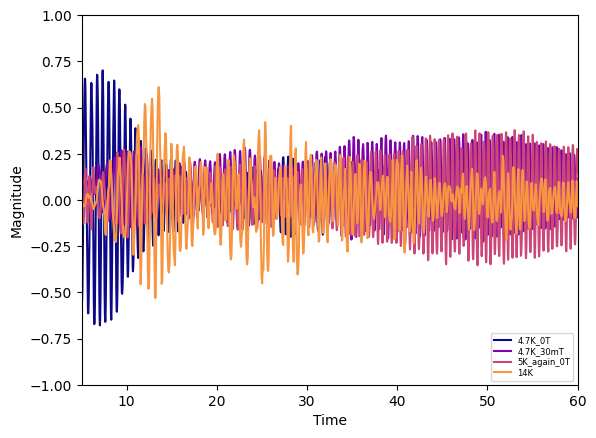

In [ ]:
#plt.figure()
cmap = plt.get_cmap('plasma')
num_lines = len(data_holder)
power =np.zeros(num_lines)
window = [-5,50]
custom_labels = ['4.7K_0T','4.7K_30mT','5K_again_0T','14K']
gain = [1,1,1,1,1,1,1,1]
#custom_labels = ['Filter_on','Filter_off']
offset_t = np.zeros(len(data_holder))
#data_holder[0].Time-=10.7
#data_holder[2].Time-=10.8
#data_holder[1].Time-=10.7
#data_holder[3].Time+=1.2
custom = True
norm = False
frame = True
off = [0.37,0.39,0.02,0,0]
lspacing = .2
plot_or_not = [True] * len(data_holder)
#plot_or_not = [True,False,True,False,False,True,True,False]
lines = ['-']*len(data_holder)

for i, data in enumerate(data_holder):
  mag = np.max(data.Signal)
  if plot_or_not[i] is True:
    if custom == True:
      offset =off
      x = data.Time
      idx_begin = np.where(x >= window[0])[0][0]
      idx_end = np.where(x <= window[1])[0][-1]
      power[i] = np.sum((data.Signal[idx_begin:idx_end])**2)
      #data.Time-=offset_t[i]
      if norm == True:
        plt.plot(data.Time, data.Signal/mag+offset,color=cmap(i / num_lines),label = custom_labels[i],ls = lines[i])
      else:
        plt.plot(data.Time-offset_t[i], data.Signal*gain[i]+offset[i],color=cmap(i / num_lines),label = custom_labels[i],ls = lines[i])
      plt.legend(loc = 'lower right', fancybox=True, labelspacing = lspacing, frameon = frame, prop={'size': 6})
    else:
      d =[data.meta['Temperature']]
      label_str = ','.join(f'{d[i]}' for i in range(len(d)))
      offset = off*i
      x = data.Time
      idx_begin = np.where(x >= window[0])[0][0]
      idx_end = np.where(x <= window[1])[0][-1]
      power[i] = np.sum((data.Signal[idx_begin:idx_end])**2)
      if norm == True:
        plt.plot(data.Time, data.Signal/mag+ offset,color=cmap(i / num_lines),ls=lines[i])
      else:
        plt.plot(data.Time, data.Signal+ offset,color=cmap(i / num_lines),label = label_str)
      plt.legend(loc = 'upper left', title='WG & Temp & HPF & Element', fancybox=True, labelspacing = lspacing, frameon = frame)


#lt.xlim(-5,50)
window = [5,60]
plt.xlim(window[0],window[1])
#plt.ylim(-0.1,0.1)
plt.ylim(-1,1)
plt.xlabel("Time")
plt.ylabel("Magnitude")

plt.show()

419 2183
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
412 2195
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
410 2194
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
117 941
FFT calculated. Attributes: positive_frequencies, positive_magnitude.


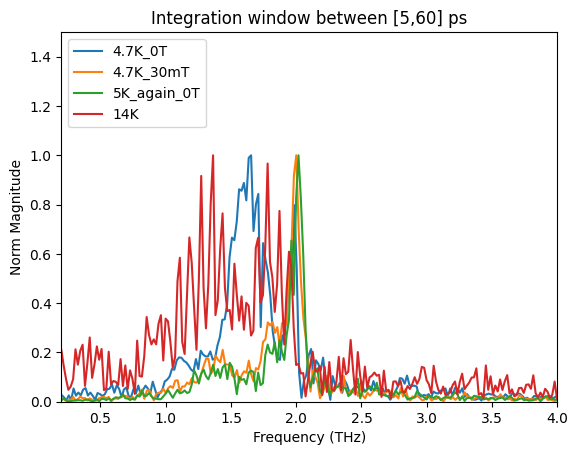

In [ ]:

#window = [5,25]
# window = [20,25]
magnitude = np.zeros_like(holder,dtype=np.float64)
#custom_labels = ['76-3.0K','75-3.0K','74-3.0K']
custom = True
frame = True
norm = True
offset =0
#ls = ls
#=============================
for i,data in enumerate(data_holder):
  data.calc_fft(window)
  magnitude[i] = np.max(data.positive_magnitude[10:])
plt.figure()
cmap = plt.get_cmap('plasma')
#==============================
for i,data in enumerate(data_holder):
  if plot_or_not[i] is True:
    if custom == True:
      if norm == True:

        plt.plot(data.positive_frequencies,
              data.positive_magnitude / magnitude[i] + i*offset,
              label =custom_labels[i])
      else:
        plt.plot(data.positive_frequencies,
              data.positive_magnitude + i*offset,
              label =custom_labels[i])
    else:
      d =[data.meta['WG'],data.meta['Temp'],data.meta['Element'], data.meta['HighPassFilterVal']]
      d = [data.meta['Temp'],data.meta['Element']]
      d = [data.meta['Temperature']]
      label_str = ','.join(f'{d[i]}' for i in range(len(d)))
      if norm == True:
        plt.plot(data.positive_frequencies,
              data.positive_magnitude / magnitude[i] + i*offset,
              label = label_str)
      else:
        plt.plot(data.positive_frequencies,
            data.positive_magnitude + i*offset,
            label = label_str)


#=================================
plt.xlabel("Frequency (THz)")
plt.ylabel("Norm Magnitude")
plt.xlim(0.2,4)
#plt.xlim(0,3)
plt.ylim(0,1.5)
plt.title(f'Integration window between [{window[0]},{window[1]}] ps')
plt.legend(loc = 'upper left', frameon = frame)
plt.show()

In [ ]:
print(data_holder[0].meta)

{'Projec Folder': 'X:\\telbe\\2024\\September\\04.09.2024', 'Date and Time': '06-09-2024_03:50', 'File Number': '086', 'Sample': 'K2IrCl6', 'THz Frequency': '0GHz', 'Power': '0.0mW', 'Type of Experiment': 'Other', 'BandPass Filters': '2500GHz', 'Wiregrid polarizer WG1': '120deg', 'Wiregrid polarizer WG2': '90deg', 'Delay Stage Start Position': '36mm', 'Delay Stage Stop Position': '46mm', 'Scan resolution': '12um', 'Horizontal binning': '5pixels'}


FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
FFT calculated. Attributes: positive_frequencies, positive_magnitude.
Error fitting Gaussian: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


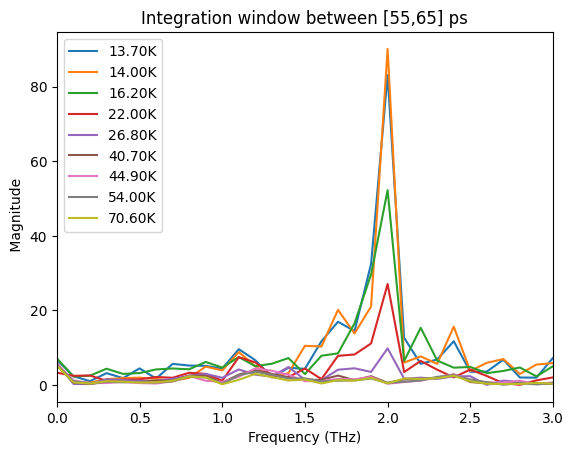

In [ ]:
val = 55
window = [val,val + 10]
#window = [8,15]
# window = [20,25]
Thz_window = [.5,2.5]

max_window = [1.85, 2.25]
magnitude = np.zeros_like(holder,dtype=np.float64)

height = np.zeros_like(holder,dtype=np.float64)
width = np.zeros_like(holder,dtype=np.float64)
center = np.zeros_like(holder,dtype=np.float64)

amp = np.zeros_like(holder,dtype=np.float64)
freq = np.zeros_like(holder,dtype=np.float64)

custom_labels = ['NF','1.4 THz HP', '2.2 THz HP']
custom = False
frame = True
norm = False
plt_gauss = True
offset =0
#ls = ls
#=============================
for i,data in enumerate(data_holder):
  data.calc_fft(window)
  idx1 = np.where(data.positive_frequencies > max_window[0])[0]
  idx2 = np.where(data.positive_frequencies[idx1] < max_window[1])[0]

  filtered_idx = idx1[idx2]
  filtered_freq = data.positive_frequencies[filtered_idx]
  filtered_values = data.positive_magnitude[filtered_idx]
  max_value = np.max(filtered_values)
  max_idx = np.argmax(filtered_values)

  amp[i] = max_value
  freq[i] = filtered_freq[max_idx]
  magnitude[i] = np.max(data.positive_magnitude)


  height[i], width[i], center[i] = data.fit_gaussian_to_range('positive_frequencies', 'positive_magnitude', Thz_window)

  globals()[f'amp_range_{window[0]}_{window[1]}_'] = amp
  globals()[f'freq_range_{window[0]}_{window[1]}_'] = freq

plt.figure()
cmap = plt.get_cmap('plasma')
#==============================
for i,data in enumerate(data_holder):
  if plot_or_not[i] is True:
    if custom == True:
      if norm == True:

        plt.plot(data.positive_frequencies,
              data.positive_magnitude / magnitude[i] + i*offset,
              label =custom_labels[i])

      else:
        plt.plot(data.positive_frequencies,
              data.positive_magnitude + i*offset,
              label =custom_labels[i])
    else:
      # d =[data.meta['WG'],data.meta['Temp'],data.meta['Element'], data.meta['HighPassFilterVal']]
      # d = [data.meta['Temp'],data.meta['Element']]
      d = [data.meta['Temperature']]
      label_str = ','.join(f'{d[i]}' for i in range(len(d)))
      if norm == True:
        plt.plot(data.positive_frequencies,
              data.positive_magnitude / magnitude[i] + i*offset,
              label = label_str)
      else:
        plt.plot(data.positive_frequencies,
            data.positive_magnitude + i*offset,
            label = label_str)


#=================================
plt.xlabel("Frequency (THz)")
plt.ylabel(" Magnitude")
plt.xlim(0,3)
# plt.ylim(-.05,1.5)
plt.title(f'Integration window between [{window[0]},{window[1]}] ps')
plt.legend(loc = 'upper left', frameon = frame)
plt.show()

In [ ]:
amp_range_55_65_

array([0.20002363, 0.20002362, 0.20002362, 0.20002362, 0.20002362,
       0.20002362, 0.20002363, 0.20002362, 0.20000527])

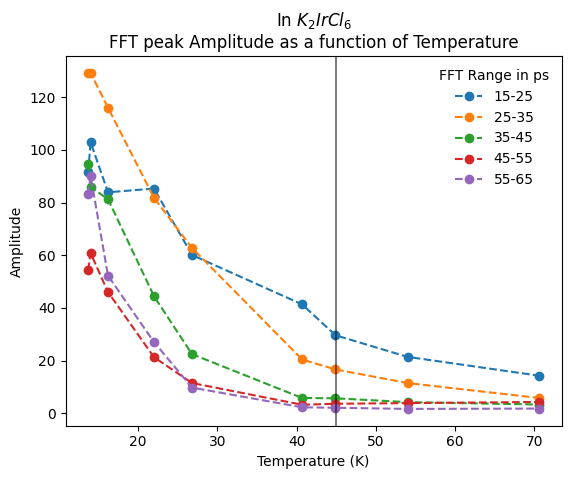

In [ ]:
plt.figure()
t = [13.7,14,16.2,22,26.8,40.7,44.9,54,70.6]

plt.plot(t,amp_range_15_25_, marker ='o', ls = '--',label = '15-25')
plt.plot(t,amp_range_25_35_, marker ='o', ls = '--', label = '25-35')
plt.plot(t,amp_range_35_45_, marker ='o', ls = '--', label = '35-45')
plt.plot(t,amp_range_45_55_, marker ='o', ls = '--', label = '45-55')
plt.plot(t,amp_range_55_65_, marker ='o', ls = '--', label = '55-65')
plt.axvline(x=45,alpha = .5, color = 'black')
plt.xlabel('Temperature (K)')
plt.ylabel('Amplitude')
plt.title(r'In $K_{2}IrCl_{6}$' '\n' 'FFT peak Amplitude as a function of Temperature')
plt.legend(title = 'FFT Range in ps', frameon = False)
plt.show()

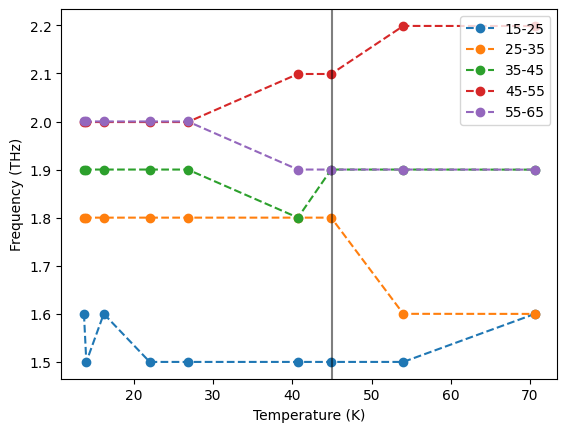

In [ ]:
plt.figure()
t = [13.7,14,16.2,22,26.8,40.7,44.9,54,70.6]

plt.plot(t,freq_range_15_25_, marker ='o', ls = '--',label = '15-25')
plt.plot(t,freq_range_25_35_, marker ='o', ls = '--', label = '25-35')
plt.plot(t,freq_range_35_45_, marker ='o', ls = '--', label = '35-45')
plt.plot(t,freq_range_45_55_, marker ='o', ls = '--', label = '45-55')
plt.plot(t,freq_range_55_65_, marker ='o', ls = '--', label = '55-65')
plt.axvline(x=45,alpha = .5, color = 'black')
plt.legend()
plt.xlabel('Temperature (K)')
plt.ylabel('Frequency (THz)')
plt.show()

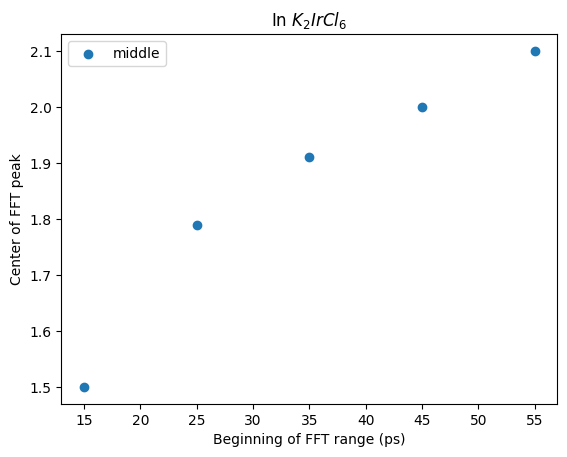

In [ ]:
plt.figure()
i = 0
#plt.scatter([15,25,35,45,55], [freq_range_15_25_[i],freq_range_25_35_[i],freq_range_35_45_[i],freq_range_45_55_[i], freq_range_55_65_[i]], label = 'calc')
plt.scatter([15,25,35,45,55], [1.5,1.79, 1.91, 2.0, 2.1], label = 'middle')
plt.xlabel('Beginning of FFT range (ps)')
plt.ylabel('Center of FFT peak')
plt.title(r'In $K_{2}IrCl_{6}$')
plt.legend()
plt.show()

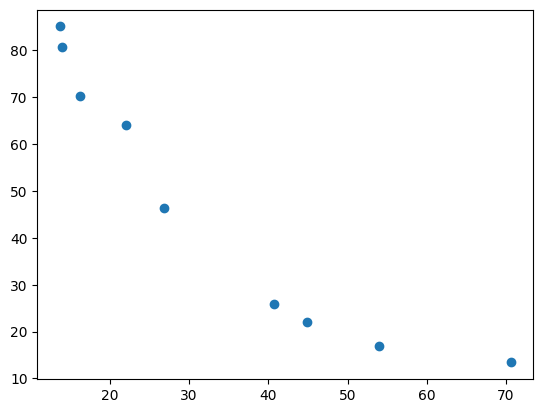

In [ ]:
plt.figure()
t = [13.7,14,16.2,22,26.8,40.7,44.9,54,70.6]

plt.plot(t,height, marker ='o', ls = 'None', )
plt.show()

Text(0, 0.5, 'Integrated over [20,30] ps')

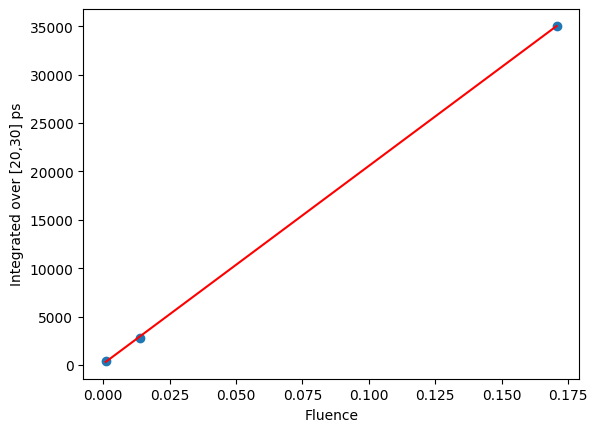

In [ ]:
def wg_to_F(wg):
  P = np.zeros_like(wg,dtype = np.float64)
  for i,w in enumerate(wg):
    P[i] = (np.cos(np.radians(w-120)))**4
  return P
wg = np.asarray([70,50,40])

P= wg_to_F(wg)

for i, data in enumerate(data_holder):
  data.meta['Fluence'] = P[i]

coefficients = np.polyfit(P, power, 1)  # 1 means a linear fit

# Get the slope and intercept
slope, intercept = coefficients

# Generate y-values for the fitted line
y_fit = slope * P + intercept
# power[-3]*=19/15
# power[-1]*=19/15
plt.scatter(P,power)
plt.plot(P,y_fit,'r')
plt.xlabel('Fluence')
plt.ylabel(f'Integrated over [{window[0]},{window[1]}] ps')

#plt.xlim(-0.04,0.1)
#plt.ylim(0,0.2)

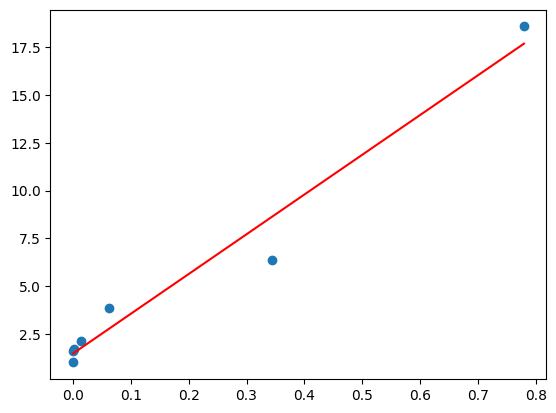

In [ ]:
plt.scatter(P,magnitude)
coefficients = np.polyfit(P, magnitude, 1)  # 1 means a linear fit

# Get the slope and intercept
slope, intercept = coefficients
# Generate y-values for the fitted line
y_fit = slope * P + intercept
plt.plot(P,y_fit,'r')
#plt.xlim(-0.04,0.1)
#plt.ylim(0,0.2)

In [ ]:
data_6.meta

{'Projec Folder': 'X:\\telbe\\2024\\September\\04.09.2024',
 'Date and Time': '04-09-2024_21:56',
 'File Number': '055',
 'Sample': 'K2SnCl6',
 'THz Frequency': '2500GHz',
 'Power': '17.0mW',
 'Type of Experiment': 'T.Dep',
 'BandPass Filters': '2500GHz',
 'Wiregrid polarizer WG1': '90deg',
 'Wiregrid polarizer WG2': '100deg',
 'Temperature': '34.00K',
 'Notes': '5 pixels binning',
 'Delay Stage Start Position': '36mm',
 'Delay Stage Stop Position': '42mm',
 'Scan resolution': '12um',
 'Horizontal binning': '5pixels'}

In [ ]:
amp

array([ 84.47330771, 102.88885024,  70.40702867,  85.28739893,
        60.0905615 ,  41.36729813,  29.66045002,  21.46768903,
         5.37811944])